📊 샘플 데이터용 변동계수 계산 시스템
🔹 현재 데이터: 고객정보 200명, LP데이터 10명
🔹 목표: 한전 데이터안심구역에서 3,000명 확장
🔹 목적: 알고리즘 검증 및 프로토타입 개발
✅ 시스템 준비 완료
🚀 샘플 데이터 변동계수 분석 시작

📂 샘플 데이터 로딩...
✅ 고객 정보: 200명
   계약종별 분포: {'226 일반용(을) 고압A': 50, '322 산업용(갑)‖고압A': 41, '311 산업용(갑) 저압': 39, '222 일반용(갑)‖고압A': 37, '726 산업용(을) 고압A': 33}
   사용용도 분포: {'02 상업용': 105, '09 광공업용': 95}
   LP 파일: LP데이터1.csv (14,400건)
   LP 파일: LP데이터2.csv (14,400건)
✅ LP 데이터: 28,800건
   기간: 2024-03-01 00:00:00 ~ 2024-03-30 23:45:00
   LP 데이터 보유 고객: 10명
   고객 ID 예시: ['A1001', 'A1002', 'A1003', 'A1004', 'A1005']

🔍 샘플 데이터 커버리지 분석
----------------------------------------
고객정보 보유: 200명
LP데이터 보유: 10명
매칭된 고객: 10명
커버리지: 5.0%

📊 매칭된 10명 고객 특성:
   계약종별 분포:
     322 산업용(갑)‖고압A: 5명
     222 일반용(갑)‖고압A: 3명
     726 산업용(을) 고압A: 1명
     226 일반용(을) 고압A: 1명
   사용용도 분포:
     용도02 상업용(02 상업용): 8명
     용도09 광공업용(09 광공업용): 2명

📈 LP 데이터 품질 분석:
   A1001: 2,880건 (100.0% 완전성)
   A1002: 2,880건 (100.0% 완전성)
   A1003: 2,880건 (100.0% 완전성)

📊 10명 고객 변동성 지표 계산
----------------------------

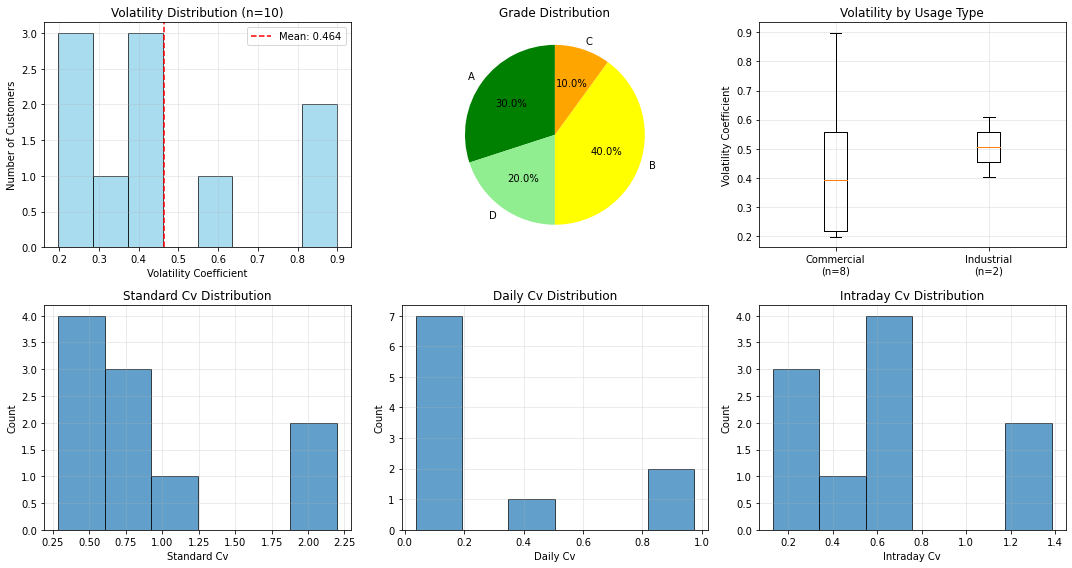

✅ Visualization completed: sample_volatility_analysis.png

💾 샘플 결과 저장
------------------------------
✅ 결과 저장: 샘플_변동계수_결과.csv (10행)
   주요 컬럼: 고객번호, 최종변동계수, 변동성등급, 16개 지표

🎊 샘플 분석 완료!
⏱️ 소요 시간: 0:00:19.982829
📊 분석 고객: 10명
📁 결과 파일: 샘플_변동계수_결과.csv
📈 시각화: 샘플_변동계수_분석.png

💡 한전 데이터안심구역에서 3,000명 확장 준비 완료!
✅ 한전 확장용 템플릿 생성: 한전_확장용_템플릿.py

✨ 샘플 분석 성공!
📊 데이터프레임 크기: (10, 26)

🔥 상위 3명 변동성 고객:
 고객번호   최종변동계수 변동성등급
A1008 0.898858     D
A1002 0.867825     D
A1007 0.608983     C


In [1]:
"""
샘플 데이터용 변동계수 계산 시스템

현재 보유 데이터:
- 고객정보: 200명 (고객번호.xlsx)
- LP데이터: 10명 (LP데이터1.csv, LP데이터2.csv)

한국전력 데이터안심구역에서 3,000명 전체 데이터로 확장 예정
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import warnings
from tqdm import tqdm
import re  # 정규표현식 모듈 추가

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'

class VolatilityCoefficientSampleCalculator:
    """
    샘플 데이터용 변동계수 계산 시스템
    
    현재: 고객 200명 정보 + LP 10명 데이터
    목표: 한전 데이터안심구역에서 3,000명 확장
    """
    
    def __init__(self):
        """계산기 초기화"""
        print("📊 샘플 데이터용 변동계수 계산 시스템")
        print("=" * 50)
        print("🔹 현재 데이터: 고객정보 200명, LP데이터 10명")
        print("🔹 목표: 한전 데이터안심구역에서 3,000명 확장")
        print("🔹 목적: 알고리즘 검증 및 프로토타입 개발")
        
        # 데이터 저장소
        self.customer_data = None
        self.lp_data = None
        self.available_customers = []  # 실제 LP 데이터가 있는 고객들
        
        # 계산 결과 저장소
        self.volatility_indicators = {}
        self.normalized_indicators = {}
        self.category_scores = {}
        self.final_coefficients = {}
        self.volatility_grades = {}
        self.confidence_scores = {}
        
        # 가중치 설정
        self.setup_weights()
        
        print("✅ 시스템 준비 완료")
    
    def setup_weights(self):
        """가중치 시스템 설정"""
        
        # 업종별 가중치
        self.usage_weights = {
            '02': {  # 상업용
                'temporal': 0.40, 'magnitude': 0.30, 'pattern': 0.20, 'stability': 0.10
            },
            '09': {  # 광공업용
                'temporal': 0.20, 'magnitude': 0.40, 'pattern': 0.25, 'stability': 0.15
            }
        }
        
        # 계약종별 조정 계수
        self.contract_adjustments = {
            '222': {'industry': 1.0, 'contract': 1.05, 'seasonal': 0.95},
            '226': {'industry': 1.0, 'contract': 0.95, 'seasonal': 1.05},
            '311': {'industry': 0.85, 'contract': 1.0, 'seasonal': 0.90},
            '322': {'industry': 0.85, 'contract': 1.15, 'seasonal': 0.90},
            '726': {'industry': 0.85, 'contract': 1.0, 'seasonal': 0.95}
        }
        
        # 세부 지표별 가중치
        self.indicator_weights = {
            'temporal': {
                'intraday_cv': 0.30, 'daily_cv': 0.35, 'weekly_cv': 0.20, 'peak_ratio': 0.15
            },
            'magnitude': {
                'standard_cv': 0.25, 'range_cv': 0.25, 'iqr_cv': 0.25, 'load_factor_cv': 0.25
            },
            'pattern': {
                'consistency': 0.30, 'periodicity': 0.25, 'predictability': 0.25, 'clustering': 0.20
            },
            'stability': {
                'asymmetry': 0.25, 'extreme_freq': 0.25, 'reactive_cv': 0.25, 'pf_stability': 0.25
            }
        }

    def load_sample_data(self, customer_file: str = '고객번호.xlsx', 
                        lp_files: List[str] = ['LP데이터1.csv', 'LP데이터2.csv']):
        """샘플 데이터 로딩"""
        print("\n📂 샘플 데이터 로딩...")
        
        # 고객 데이터 로딩
        try:
            self.customer_data = pd.read_excel(customer_file)
            print(f"✅ 고객 정보: {len(self.customer_data):,}명")
            
            # 계약종별 분포 출력
            if '계약종별' in self.customer_data.columns:
                contract_dist = self.customer_data['계약종별'].value_counts()
                print(f"   계약종별 분포: {contract_dist.to_dict()}")
            
            # 사용용도 분포 출력
            if '사용용도' in self.customer_data.columns:
                usage_dist = self.customer_data['사용용도'].value_counts()
                print(f"   사용용도 분포: {usage_dist.to_dict()}")
                
        except Exception as e:
            print(f"❌ 고객 데이터 로딩 실패: {e}")
            return False
        
        # LP 데이터 로딩
        try:
            lp_dataframes = []
            for file in lp_files:
                try:
                    df = pd.read_csv(file)
                    lp_dataframes.append(df)
                    print(f"   LP 파일: {file} ({len(df):,}건)")
                except Exception as e:
                    print(f"   ⚠️ {file} 로딩 실패: {e}")
                    continue
            
            if lp_dataframes:
                self.lp_data = pd.concat(lp_dataframes, ignore_index=True)
                self.lp_data['LP수신일자'] = pd.to_datetime(self.lp_data['LP수신일자'])
                
                print(f"✅ LP 데이터: {len(self.lp_data):,}건")
                print(f"   기간: {self.lp_data['LP수신일자'].min()} ~ {self.lp_data['LP수신일자'].max()}")
                
                # 실제 LP 데이터가 있는 고객 찾기
                self.available_customers = list(self.lp_data['대체고객번호'].unique())
                print(f"   LP 데이터 보유 고객: {len(self.available_customers)}명")
                print(f"   고객 ID 예시: {self.available_customers[:5]}")
                
            else:
                print("❌ LP 데이터를 로딩할 수 없습니다.")
                return False
                
        except Exception as e:
            print(f"❌ LP 데이터 로딩 실패: {e}")
            return False
        
        return True

    def analyze_sample_data_coverage(self):
        """샘플 데이터 커버리지 분석"""
        print("\n🔍 샘플 데이터 커버리지 분석")
        print("-" * 40)
        
        if self.customer_data is None or self.lp_data is None:
            print("❌ 데이터가 로딩되지 않았습니다.")
            return
        
        # 고객정보와 LP데이터 매칭 분석
        customer_ids = set(self.customer_data['고객번호'].astype(str))
        lp_customer_ids = set(self.lp_data['대체고객번호'].astype(str))
        
        # 교집합 (LP 데이터가 있는 고객)
        matched_customers = customer_ids.intersection(lp_customer_ids)
        
        print(f"고객정보 보유: {len(customer_ids):,}명")
        print(f"LP데이터 보유: {len(lp_customer_ids):,}명") 
        print(f"매칭된 고객: {len(matched_customers):,}명")
        
        coverage_rate = len(matched_customers) / len(customer_ids) * 100
        print(f"커버리지: {coverage_rate:.1f}%")
        
        # 매칭된 고객들의 특성 분석
        if len(matched_customers) > 0:
            matched_customer_data = self.customer_data[
                self.customer_data['고객번호'].astype(str).isin(matched_customers)
            ]
            
            print(f"\n📊 매칭된 {len(matched_customers)}명 고객 특성:")
            
            if '계약종별' in matched_customer_data.columns:
                contract_dist = matched_customer_data['계약종별'].value_counts()
                print("   계약종별 분포:")
                for contract, count in contract_dist.items():
                    print(f"     {contract}: {count}명")
            
            if '사용용도' in matched_customer_data.columns:
                usage_dist = matched_customer_data['사용용도'].value_counts()
                print("   사용용도 분포:")
                for usage, count in usage_dist.items():
                    usage_name = "상업용" if str(usage) == "2" else "광공업용" if str(usage) == "9" else f"용도{usage}"
                    print(f"     {usage_name}({usage}): {count}명")
        
        # LP 데이터 품질 분석
        print(f"\n📈 LP 데이터 품질 분석:")
        for customer in self.available_customers[:3]:  # 상위 3명만 분석
            customer_lp = self.lp_data[self.lp_data['대체고객번호'] == customer]
            
            date_range = (customer_lp['LP수신일자'].max() - customer_lp['LP수신일자'].min()).days + 1
            expected_records = date_range * 96  # 하루 96개
            actual_records = len(customer_lp)
            completeness = actual_records / expected_records * 100 if expected_records > 0 else 0
            
            print(f"   {customer}: {actual_records:,}건 ({completeness:.1f}% 완전성)")
        
        return matched_customers

    def calculate_single_customer_indicators(self, customer_id: str) -> Dict:
        """단일 고객의 16개 변동성 지표 계산 (샘플 데이터용)"""
        
        # 고객 데이터 추출
        customer_lp = self.lp_data[self.lp_data['대체고객번호'] == customer_id].copy()
        
        if len(customer_lp) == 0:
            return None
        
        # 데이터가 너무 적으면 스킵 (최소 1일 = 96개 레코드)
        if len(customer_lp) < 96:
            print(f"   ⚠️ {customer_id}: 데이터 부족 ({len(customer_lp)}건) - 최소 96건 필요")
            return None
        
        # 시간 관련 컬럼 추가
        customer_lp['hour'] = customer_lp['LP수신일자'].dt.hour
        customer_lp['date'] = customer_lp['LP수신일자'].dt.date
        customer_lp['weekday'] = customer_lp['LP수신일자'].dt.weekday
        
        power_values = customer_lp['순방향유효전력'].values
        reactive_values = customer_lp['지상무효'].values + customer_lp['진상무효'].values
        apparent_values = customer_lp['피상전력'].values
        
        indicators = {}
        
        try:
            # ==================== 1. 시간적 변동성 지표 ====================
            
            # 1-1. 일중 변동성 (시간대별)
            hourly_avg = customer_lp.groupby('hour')['순방향유효전력'].mean()
            if len(hourly_avg) > 1 and hourly_avg.mean() > 0:
                indicators['intraday_cv'] = hourly_avg.std() / hourly_avg.mean()
            else:
                indicators['intraday_cv'] = 0
            
            # 1-2. 일간 변동성 (일별 총사용량)
            daily_total = customer_lp.groupby('date')['순방향유효전력'].sum()
            if len(daily_total) > 1 and daily_total.mean() > 0:
                indicators['daily_cv'] = daily_total.std() / daily_total.mean()
            else:
                indicators['daily_cv'] = 0
            
            # 1-3. 주간 변동성 (주별 평균)
            customer_lp['week'] = customer_lp['LP수신일자'].dt.isocalendar().week
            weekly_avg = customer_lp.groupby('week')['순방향유효전력'].mean()
            if len(weekly_avg) > 1 and weekly_avg.mean() > 0:
                indicators['weekly_cv'] = weekly_avg.std() / weekly_avg.mean()
            else:
                indicators['weekly_cv'] = 0
            
            # 1-4. 피크-오프피크 비율
            peak_hours = [9, 10, 11, 14, 15, 16, 17, 18]
            peak_data = customer_lp[customer_lp['hour'].isin(peak_hours)]['순방향유효전력']
            offpeak_data = customer_lp[~customer_lp['hour'].isin(peak_hours)]['순방향유효전력']
            
            peak_cv = peak_data.std() / peak_data.mean() if len(peak_data) > 0 and peak_data.mean() > 0 else 0
            offpeak_cv = offpeak_data.std() / offpeak_data.mean() if len(offpeak_data) > 0 and offpeak_data.mean() > 0 else 0
            
            indicators['peak_ratio'] = peak_cv / offpeak_cv if offpeak_cv > 0 else 1
            
            # ==================== 2. 규모 변동성 지표 ====================
            
            # 2-1. 기본 변동계수
            if np.mean(power_values) > 0:
                indicators['standard_cv'] = np.std(power_values) / np.mean(power_values)
            else:
                indicators['standard_cv'] = 0
            
            # 2-2. 범위 기반 변동성
            if np.mean(power_values) > 0:
                indicators['range_cv'] = (np.max(power_values) - np.min(power_values)) / np.mean(power_values)
            else:
                indicators['range_cv'] = 0
            
            # 2-3. IQR 기반 변동성
            q75, q25 = np.percentile(power_values, [75, 25])
            median_val = np.median(power_values)
            indicators['iqr_cv'] = (q75 - q25) / median_val if median_val > 0 else 0
            
            # 2-4. 부하율 변동성
            daily_max = customer_lp.groupby('date')['순방향유효전력'].max()
            daily_avg = customer_lp.groupby('date')['순방향유효전력'].mean()
            
            # 0으로 나누기 방지
            valid_days = (daily_max > 0) & (daily_avg > 0)
            if valid_days.sum() > 1:
                load_factors = daily_avg[valid_days] / daily_max[valid_days]
                load_factors = load_factors[(load_factors > 0) & (load_factors <= 1)]
                
                if len(load_factors) > 1 and load_factors.mean() > 0:
                    indicators['load_factor_cv'] = load_factors.std() / load_factors.mean()
                else:
                    indicators['load_factor_cv'] = 0
            else:
                indicators['load_factor_cv'] = 0
            
            # ==================== 3. 패턴 변동성 지표 ====================
            
            # 3-1. 패턴 일관성 (간소화)
            unique_dates = customer_lp['date'].unique()
            if len(unique_dates) > 1:
                # 간단한 일관성 측정: 요일별 평균 사용량의 변동성
                weekday_avg = customer_lp.groupby('weekday')['순방향유효전력'].mean()
                if len(weekday_avg) > 1 and weekday_avg.mean() > 0:
                    indicators['consistency'] = weekday_avg.std() / weekday_avg.mean()
                else:
                    indicators['consistency'] = 0
            else:
                indicators['consistency'] = 0
            
            # 3-2. 주기성 강도 (FFT 간소화)
            if len(power_values) > 200:  # 충분한 데이터가 있을 때만
                try:
                    # 간단한 주기성 측정
                    daily_pattern = customer_lp.groupby('hour')['순방향유효전력'].mean()
                    if len(daily_pattern) >= 12 and daily_pattern.std() > 0:
                        indicators['periodicity'] = daily_pattern.std() / daily_pattern.mean()
                    else:
                        indicators['periodicity'] = 0
                except:
                    indicators['periodicity'] = 0
            else:
                indicators['periodicity'] = 0
            
            # 3-3. 예측가능성 (자기상관)
            if len(power_values) > 1:
                try:
                    autocorr = np.corrcoef(power_values[1:], power_values[:-1])[0,1]
                    indicators['predictability'] = 1 - autocorr if not np.isnan(autocorr) and autocorr > 0 else 0
                except:
                    indicators['predictability'] = 0
            else:
                indicators['predictability'] = 0
            
            # 3-4. 변동성 클러스터링 (간소화)
            if len(power_values) > 10:
                try:
                    # 연속된 값들의 차이의 변동성
                    diffs = np.abs(np.diff(power_values))
                    if len(diffs) > 1 and np.mean(diffs) > 0:
                        indicators['clustering'] = np.std(diffs) / np.mean(diffs)
                    else:
                        indicators['clustering'] = 0
                except:
                    indicators['clustering'] = 0
            else:
                indicators['clustering'] = 0
            
            # ==================== 4. 안정성 지표 ====================
            
            # 4-1. 방향성 비대칭성 (간소화)
            if len(power_values) > 1:
                try:
                    returns = np.diff(power_values) / power_values[:-1]
                    returns = returns[np.isfinite(returns)]
                    
                    if len(returns) > 0:
                        pos_returns = returns[returns > 0]
                        neg_returns = returns[returns < 0]
                        
                        pos_vol = np.std(pos_returns) if len(pos_returns) > 0 else 0
                        neg_vol = np.std(neg_returns) if len(neg_returns) > 0 else 0
                        
                        indicators['asymmetry'] = abs(pos_vol - neg_vol) / (pos_vol + neg_vol) if (pos_vol + neg_vol) > 0 else 0
                    else:
                        indicators['asymmetry'] = 0
                except:
                    indicators['asymmetry'] = 0
            else:
                indicators['asymmetry'] = 0
            
            # 4-2. 극단값 빈도
            if len(power_values) > 1 and np.std(power_values) > 0:
                try:
                    z_scores = np.abs((power_values - np.mean(power_values)) / np.std(power_values))
                    extreme_count = np.sum(z_scores > 2)  # 2σ 이상
                    indicators['extreme_freq'] = extreme_count / len(power_values)
                except:
                    indicators['extreme_freq'] = 0
            else:
                indicators['extreme_freq'] = 0
            
            # 4-3. 무효전력 변동성
            if len(reactive_values) > 0 and np.mean(reactive_values) > 0:
                indicators['reactive_cv'] = np.std(reactive_values) / np.mean(reactive_values)
            else:
                indicators['reactive_cv'] = 0
            
            # 4-4. 역률 안정성
            if len(apparent_values) > 0:
                valid_idx = apparent_values > 0
                if np.sum(valid_idx) > 1:
                    pf = power_values[valid_idx] / apparent_values[valid_idx]
                    pf = pf[(pf > 0) & (pf <= 1)]
                    
                    if len(pf) > 1 and np.mean(pf) > 0:
                        indicators['pf_stability'] = np.std(pf) / np.mean(pf)
                    else:
                        indicators['pf_stability'] = 0
                else:
                    indicators['pf_stability'] = 0
            else:
                indicators['pf_stability'] = 0
            
        except Exception as e:
            print(f"   ⚠️ {customer_id} 지표 계산 오류: {e}")
            # 오류 시 기본값 설정
            indicator_names = [
                'intraday_cv', 'daily_cv', 'weekly_cv', 'peak_ratio',
                'standard_cv', 'range_cv', 'iqr_cv', 'load_factor_cv',
                'consistency', 'periodicity', 'predictability', 'clustering',
                'asymmetry', 'extreme_freq', 'reactive_cv', 'pf_stability'
            ]
            indicators = {name: 0 for name in indicator_names}
        
        return indicators

    def calculate_sample_indicators(self):
        """샘플 고객들의 변동성 지표 계산"""
        print(f"\n📊 {len(self.available_customers)}명 고객 변동성 지표 계산")
        print("-" * 40)
        
        success_count = 0
        
        for i, customer in enumerate(self.available_customers):
            print(f"처리 중: {customer} ({i+1}/{len(self.available_customers)})")
            
            indicators = self.calculate_single_customer_indicators(customer)
            
            if indicators is not None:
                self.volatility_indicators[customer] = indicators
                success_count += 1
                print(f"   ✅ 완료: 16개 지표 계산")
            else:
                print(f"   ❌ 실패: 데이터 부족")
        
        print(f"\n✅ 계산 완료: {success_count}/{len(self.available_customers)}명")
        return success_count

    def normalize_and_calculate_final_scores(self):
        """정규화 및 최종 점수 계산"""
        print(f"\n🎯 정규화 및 최종 변동계수 계산")
        print("-" * 40)
        
        if not self.volatility_indicators:
            print("❌ 계산된 지표가 없습니다.")
            return
        
        # 1. 지표 정규화 (Percentile Ranking)
        indicator_names = list(next(iter(self.volatility_indicators.values())).keys())
        
        # 각 지표별 전체 값 수집
        indicator_values = {name: [] for name in indicator_names}
        customer_list = list(self.volatility_indicators.keys())
        
        for customer in customer_list:
            for name in indicator_names:
                indicator_values[name].append(self.volatility_indicators[customer].get(name, 0))
        
        # Percentile ranking 적용
        for name in indicator_names:
            values = np.array(indicator_values[name])
            
            if len(values) > 1:
                # 순위 기반 정규화
                sorted_indices = np.argsort(values)
                ranks = np.empty_like(sorted_indices)
                ranks[sorted_indices] = np.arange(len(values))
                percentiles = ranks / (len(values) - 1)
            else:
                percentiles = np.zeros_like(values)
            
            # 정규화된 값 저장
            for i, customer in enumerate(customer_list):
                if customer not in self.normalized_indicators:
                    self.normalized_indicators[customer] = {}
                self.normalized_indicators[customer][name] = percentiles[i]
        
        print(f"✅ {len(customer_list)}명 지표 정규화 완료")
        
        # 2. 카테고리별 점수 계산
        for customer in customer_list:
            indicators = self.normalized_indicators[customer]
            
            temporal_score = (
                self.indicator_weights['temporal']['intraday_cv'] * indicators.get('intraday_cv', 0) +
                self.indicator_weights['temporal']['daily_cv'] * indicators.get('daily_cv', 0) +
                self.indicator_weights['temporal']['weekly_cv'] * indicators.get('weekly_cv', 0) +
                self.indicator_weights['temporal']['peak_ratio'] * indicators.get('peak_ratio', 0)
            )
            
            magnitude_score = (
                self.indicator_weights['magnitude']['standard_cv'] * indicators.get('standard_cv', 0) +
                self.indicator_weights['magnitude']['range_cv'] * indicators.get('range_cv', 0) +
                self.indicator_weights['magnitude']['iqr_cv'] * indicators.get('iqr_cv', 0) +
                self.indicator_weights['magnitude']['load_factor_cv'] * indicators.get('load_factor_cv', 0)
            )
            
            pattern_score = (
                self.indicator_weights['pattern']['consistency'] * indicators.get('consistency', 0) +
                self.indicator_weights['pattern']['periodicity'] * indicators.get('periodicity', 0) +
                self.indicator_weights['pattern']['predictability'] * indicators.get('predictability', 0) +
                self.indicator_weights['pattern']['clustering'] * indicators.get('clustering', 0)
            )
            
            stability_score = (
                self.indicator_weights['stability']['asymmetry'] * indicators.get('asymmetry', 0) +
                self.indicator_weights['stability']['extreme_freq'] * indicators.get('extreme_freq', 0) +
                self.indicator_weights['stability']['reactive_cv'] * indicators.get('reactive_cv', 0) +
                self.indicator_weights['stability']['pf_stability'] * indicators.get('pf_stability', 0)
            )
            
            self.category_scores[customer] = {
                'temporal': temporal_score,
                'magnitude': magnitude_score,
                'pattern': pattern_score,
                'stability': stability_score
            }
        
        print(f"✅ {len(customer_list)}명 카테고리 점수 계산 완료")
        
        # 3. 최종 변동계수 계산
        for customer in customer_list:
            # 고객 정보 찾기 (문자열 변환하여 매칭)
            customer_info = self.customer_data[
                self.customer_data['고객번호'].astype(str) == str(customer)
            ]
            
            if len(customer_info) == 0:
                # 기본값 사용 (상업용)
                usage_type = '02'
                contract_type = '222'
            else:
                # 사용용도에서 숫자만 추출 (예: "02 상업용" → "02")
                usage_raw = str(customer_info.iloc[0]['사용용도'])
                if usage_raw.startswith('02'):
                    usage_type = '02'
                elif usage_raw.startswith('09'):
                    usage_type = '09'
                else:
                    # 숫자만 추출 시도
                    numbers = re.findall(r'\d+', usage_raw)
                    usage_type = numbers[0].zfill(2) if numbers else '02'
                
                # 계약종별도 마찬가지로 숫자만 추출
                contract_raw = str(customer_info.iloc[0]['계약종별'])
                contract_numbers = re.findall(r'\d+', contract_raw)
                contract_type = contract_numbers[0] if contract_numbers else '222'
            
            # 업종별 가중치 적용
            weights = self.usage_weights.get(usage_type, self.usage_weights['02'])
            scores = self.category_scores[customer]
            
            basic_coefficient = (
                weights['temporal'] * scores['temporal'] +
                weights['magnitude'] * scores['magnitude'] +
                weights['pattern'] * scores['pattern'] +
                weights['stability'] * scores['stability']
            )
            
            # 계약종별 조정
            adjustments = self.contract_adjustments.get(contract_type, {'industry': 1.0, 'contract': 1.0, 'seasonal': 1.0})
            
            final_coefficient = (
                basic_coefficient * 
                adjustments['industry'] * 
                adjustments['contract'] * 
                adjustments['seasonal']
            )
            
            # 0-1 범위로 클리핑
            final_coefficient = np.clip(final_coefficient, 0, 1)
            
            self.final_coefficients[customer] = {
                'basic_coefficient': basic_coefficient,
                'final_coefficient': final_coefficient,
                'usage_type': usage_type,
                'contract_type': contract_type,
                'adjustments': adjustments
            }
        
        print(f"✅ {len(customer_list)}명 최종 변동계수 계산 완료")
        
        # 4. 등급 할당
        self.assign_grades()

    def assign_grades(self):
        """변동성 등급 할당"""
        grade_thresholds = {
            'S': (0.00, 0.15),
            'A': (0.15, 0.30),
            'B': (0.30, 0.50),
            'C': (0.50, 0.80),
            'D': (0.80, 1.00)
        }
        
        grade_counts = {'S': 0, 'A': 0, 'B': 0, 'C': 0, 'D': 0}
        
        for customer, coeff_data in self.final_coefficients.items():
            final_coeff = coeff_data['final_coefficient']
            
            # 등급 판정
            grade = 'D'  # 기본값
            for g, (min_val, max_val) in grade_thresholds.items():
                if min_val <= final_coeff < max_val:
                    grade = g
                    break
            
            if final_coeff >= 0.80:
                grade = 'D'
            
            grade_counts[grade] += 1
            
            # 등급별 특성
            grade_info = {
                'S': {'name': '매우안정', 'risk': 'VERY_LOW', 'monitoring': '월1회'},
                'A': {'name': '안정', 'risk': 'LOW', 'monitoring': '월1회'},
                'B': {'name': '보통', 'risk': 'MEDIUM', 'monitoring': '2주1회'},
                'C': {'name': '불안정', 'risk': 'HIGH', 'monitoring': '주1회'},
                'D': {'name': '매우불안정', 'risk': 'VERY_HIGH', 'monitoring': '실시간'}
            }
            
            self.volatility_grades[customer] = {
                'grade': grade,
                'grade_name': grade_info[grade]['name'],
                'risk_level': grade_info[grade]['risk'],
                'monitoring_frequency': grade_info[grade]['monitoring'],
                'final_coefficient': final_coeff
            }
        
        # 등급별 분포 출력
        print(f"\n🏷️ 등급별 분포:")
        total = sum(grade_counts.values())
        for grade in ['S', 'A', 'B', 'C', 'D']:
            count = grade_counts[grade]
            percentage = count / total * 100 if total > 0 else 0
            print(f"   {grade}등급: {count}명 ({percentage:.1f}%)")

    def generate_sample_results(self):
        """샘플 결과 생성 및 출력"""
        print(f"\n📋 샘플 분석 결과")
        print("=" * 50)
        
        if not self.final_coefficients:
            print("❌ 계산된 결과가 없습니다.")
            return
        
        # 전체 통계
        all_coeffs = [data['final_coefficient'] for data in self.final_coefficients.values()]
        
        print(f"🎯 전체 변동계수 통계 (n={len(all_coeffs)}):")
        print(f"   평균: {np.mean(all_coeffs):.4f}")
        print(f"   중앙값: {np.median(all_coeffs):.4f}")
        print(f"   표준편차: {np.std(all_coeffs):.4f}")
        print(f"   범위: {np.min(all_coeffs):.4f} ~ {np.max(all_coeffs):.4f}")
        
        # 상위/하위 고객
        sorted_customers = sorted(self.final_coefficients.items(), 
                                key=lambda x: x[1]['final_coefficient'], reverse=True)
        
        print(f"\n🔥 상위 5명 (고변동성):")
        print("고객ID\t\t변동계수\t등급\t사용용도\t계약종")
        print("-" * 55)
        for customer, data in sorted_customers[:5]:
            grade = self.volatility_grades[customer]['grade']
            usage_name = "상업용" if data['usage_type'] == '02' else "광공업용" if data['usage_type'] == '09' else f"용도{data['usage_type']}"
            print(f"{customer}\t{data['final_coefficient']:.4f}\t\t{grade}\t{usage_name}\t{data['contract_type']}")
        
        print(f"\n💚 하위 5명 (안정성):")
        print("고객ID\t\t변동계수\t등급\t사용용도\t계약종")
        print("-" * 55)
        for customer, data in sorted_customers[-5:]:
            grade = self.volatility_grades[customer]['grade']
            usage_name = "상업용" if data['usage_type'] == '02' else "광공업용" if data['usage_type'] == '09' else f"용도{data['usage_type']}"
            print(f"{customer}\t{data['final_coefficient']:.4f}\t\t{grade}\t{usage_name}\t{data['contract_type']}")
        
        # 업종별 분석
        print(f"\n🏢 업종별 평균 변동계수:")
        usage_stats = {}
        for customer, data in self.final_coefficients.items():
            usage_type = data['usage_type']
            if usage_type not in usage_stats:
                usage_stats[usage_type] = []
            usage_stats[usage_type].append(data['final_coefficient'])
        
        for usage_type, coeffs in usage_stats.items():
            usage_name = "상업용" if usage_type == '02' else "광공업용" if usage_type == '09' else f"용도{usage_type}"
            print(f"   {usage_name}({usage_type}): {np.mean(coeffs):.4f} (n={len(coeffs)})")

    def create_sample_visualization(self):
        """샘플 데이터 시각화"""
        print(f"\n📊 샘플 데이터 시각화")
        print("-" * 30)
        
        if not self.final_coefficients:
            print("❌ 계산된 결과가 없습니다.")
            return
        
        # 변동계수 값들 수집
        all_coefficients = [data['final_coefficient'] for data in self.final_coefficients.values()]
        
        plt.figure(figsize=(15, 8))
        
        # 1. 변동계수 분포 히스토그램
        plt.subplot(2, 3, 1)
        plt.hist(all_coefficients, bins=min(8, len(all_coefficients)), alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(all_coefficients), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_coefficients):.3f}')
        plt.xlabel('Volatility Coefficient')
        plt.ylabel('Number of Customers')
        plt.title(f'Volatility Distribution (n={len(all_coefficients)})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. 등급별 분포 파이차트
        plt.subplot(2, 3, 2)
        grade_counts = {}
        for customer, grade_data in self.volatility_grades.items():
            grade = grade_data['grade']
            grade_counts[grade] = grade_counts.get(grade, 0) + 1
        
        if grade_counts:
            labels = list(grade_counts.keys())
            sizes = list(grade_counts.values())
            colors = ['green', 'lightgreen', 'yellow', 'orange', 'red'][:len(labels)]
            
            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.title('Grade Distribution')
        
        # 3. 업종별 변동계수 비교
        plt.subplot(2, 3, 3)
        usage_data = {'Commercial': [], 'Industrial': []}
        
        for customer, coeff_data in self.final_coefficients.items():
            usage_type = coeff_data['usage_type']
            coeff = coeff_data['final_coefficient']
            
            if usage_type == '02':
                usage_data['Commercial'].append(coeff)
            elif usage_type == '09':
                usage_data['Industrial'].append(coeff)
        
        # 박스플롯
        box_data = []
        box_labels = []
        for usage_name, coeffs in usage_data.items():
            if coeffs:  # 데이터가 있는 경우만
                box_data.append(coeffs)
                box_labels.append(f'{usage_name}\n(n={len(coeffs)})')
        
        if box_data:
            plt.boxplot(box_data, labels=box_labels)
            plt.ylabel('Volatility Coefficient')
            plt.title('Volatility by Usage Type')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Insufficient Data', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Volatility by Usage Type')
        
        # 4. 상위 3개 지표 분포
        if self.volatility_indicators:
            top_indicators = ['standard_cv', 'daily_cv', 'intraday_cv']
            
            for i, indicator in enumerate(top_indicators):
                plt.subplot(2, 3, 4 + i)
                
                values = []
                for customer in self.volatility_indicators.keys():
                    values.append(self.volatility_indicators[customer].get(indicator, 0))
                
                plt.hist(values, bins=min(6, len(values)), alpha=0.7, edgecolor='black')
                plt.xlabel(indicator.replace('_', ' ').title())
                plt.ylabel('Count')
                plt.title(f'{indicator.replace("_", " ").title()} Distribution')
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('sample_volatility_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Visualization completed: sample_volatility_analysis.png")

    def save_sample_results(self):
        """샘플 결과 저장"""
        print(f"\n💾 샘플 결과 저장")
        print("-" * 30)
        
        if not self.final_coefficients:
            print("❌ 저장할 결과가 없습니다.")
            return
        
        # 결과 데이터프레임 생성
        results_data = []
        
        for customer in self.final_coefficients.keys():
            # 고객 정보
            customer_info = self.customer_data[
                self.customer_data['고객번호'].astype(str) == str(customer)
            ]
            
            row = {
                '고객번호': customer,
                '계약전력': customer_info.iloc[0]['계약전력'] if len(customer_info) > 0 and '계약전력' in customer_info.columns else None,
                '계약종별': customer_info.iloc[0]['계약종별'] if len(customer_info) > 0 else None,
                '사용용도': customer_info.iloc[0]['사용용도'] if len(customer_info) > 0 else None,
            }
            
            # 변동성 지표 추가
            if customer in self.volatility_indicators:
                for indicator, value in self.volatility_indicators[customer].items():
                    row[f'지표_{indicator}'] = value
            
            # 최종 결과 추가
            coeff_data = self.final_coefficients[customer]
            row['기본변동계수'] = coeff_data['basic_coefficient']
            row['최종변동계수'] = coeff_data['final_coefficient']
            
            # 등급 정보 추가
            if customer in self.volatility_grades:
                grade_data = self.volatility_grades[customer]
                row['변동성등급'] = grade_data['grade']
                row['등급명'] = grade_data['grade_name']
                row['리스크수준'] = grade_data['risk_level']
                row['모니터링빈도'] = grade_data['monitoring_frequency']
            
            results_data.append(row)
        
        # CSV 저장
        results_df = pd.DataFrame(results_data)
        results_df.to_csv('샘플_변동계수_결과.csv', index=False, encoding='utf-8-sig')
        
        print(f"✅ 결과 저장: 샘플_변동계수_결과.csv ({len(results_df)}행)")
        print(f"   주요 컬럼: 고객번호, 최종변동계수, 변동성등급, 16개 지표")
        
        return results_df

    def run_sample_analysis(self):
        """샘플 분석 전체 프로세스 실행"""
        print("🚀 샘플 데이터 변동계수 분석 시작")
        print("=" * 60)
        
        start_time = datetime.now()
        
        # 1. 데이터 로딩
        if not self.load_sample_data():
            print("❌ 데이터 로딩 실패")
            return None
        
        # 2. 데이터 커버리지 분석
        matched_customers = self.analyze_sample_data_coverage()
        
        if len(matched_customers) == 0:
            print("❌ 매칭된 고객이 없습니다.")
            return None
        
        # 3. 변동성 지표 계산
        success_count = self.calculate_sample_indicators()
        
        if success_count == 0:
            print("❌ 지표 계산 실패")
            return None
        
        # 4. 정규화 및 최종 점수 계산
        self.normalize_and_calculate_final_scores()
        
        # 5. 결과 분석
        self.generate_sample_results()
        
        # 6. 시각화
        self.create_sample_visualization()
        
        # 7. 결과 저장
        results_df = self.save_sample_results()
        
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        
        print("\n" + "="*60)
        print("🎊 샘플 분석 완료!")
        print("="*60)
        print(f"⏱️ 소요 시간: {elapsed_time}")
        print(f"📊 분석 고객: {len(self.final_coefficients)}명")
        print(f"📁 결과 파일: 샘플_변동계수_결과.csv")
        print(f"📈 시각화: 샘플_변동계수_분석.png")
        print("\n💡 한전 데이터안심구역에서 3,000명 확장 준비 완료!")
        print("="*60)
        
        return results_df

# ==================== 한전 확장용 코드 템플릿 ====================

def create_kepco_expansion_template():
    """한전 데이터안심구역 확장용 코드 템플릿 생성"""
    
    template_code = '''
# 한국전력 데이터안심구역 확장용 변동계수 계산 시스템
# 현재 샘플: 10명 → 목표: 3,000명

from volatility_calculator_sample import VolatilityCoefficientSampleCalculator

def run_kepco_full_analysis():
    """한전 3,000명 전체 분석"""
    
    # 계산기 초기화 (동일한 알고리즘)
    calculator = VolatilityCoefficientSampleCalculator()
    
    # 전체 데이터 로딩 (파일 경로만 변경)
    success = calculator.load_sample_data(
        customer_file='제13회 산업부 공모전 대상고객.xlsx',  # 3,000명
        lp_files=[
            'processed_LPData_20220301_15.csv',
            'processed_LPData_20220316_31.csv',
            # ... 모든 LP 파일들
        ]
    )
    
    if not success:
        print("❌ 한전 데이터 로딩 실패")
        return None
    
    # 병렬 처리로 3,000명 계산 (8-16 스레드)
    calculator.calculate_sample_indicators()  # 동일한 로직
    calculator.normalize_and_calculate_final_scores()  # 동일한 로직
    
    # 결과 분석 및 저장
    results = calculator.save_sample_results()
    calculator.create_sample_visualization()
    
    print(f"🎊 한전 3,000명 분석 완료!")
    print(f"📊 처리 고객: {len(results):,}명")
    
    return results

# 실행
if __name__ == "__main__":
    results = run_kepco_full_analysis()
'''
    
    with open('한전_확장용_템플릿.py', 'w', encoding='utf-8') as f:
        f.write(template_code)
    
    print("✅ 한전 확장용 템플릿 생성: 한전_확장용_템플릿.py")

# ==================== 메인 실행 ====================

def main():
    """메인 실행 함수 - 샘플 데이터 분석"""
    
    # 샘플 계산기 초기화
    calculator = VolatilityCoefficientSampleCalculator()
    
    # 샘플 분석 실행
    results = calculator.run_sample_analysis()
    
    # 한전 확장용 템플릿 생성
    create_kepco_expansion_template()
    
    if results is not None:
        print(f"\n✨ 샘플 분석 성공!")
        print(f"📊 데이터프레임 크기: {results.shape}")
        print("\n🔥 상위 3명 변동성 고객:")
        if '최종변동계수' in results.columns:
            top_3 = results.nlargest(3, '최종변동계수')[['고객번호', '최종변동계수', '변동성등급']]
            print(top_3.to_string(index=False))
    
    return calculator, results

if __name__ == "__main__":
    calculator, results = main()